# 9주차 Recommand System Basic 과제
----

1. 파이썬을 이용하여 무비렌즈 데이터(ml-latest-small)를 전처리 후 EDA까지 진행해주세요.
 - 유의미한 분석이 5개 이상 포함되어있어야 합니다!
 
2. Memory based CF 2개 이상, Model based CF 2개 이상의 알고리즘을 사용하여, 아래 결과를 출력해주세요.
 - 성능 평가
 - 추천 결과 출력

* 이때, Suprise library를 사용해도 됩니다!

# 1. 무비렌즈 데이터 전처리 및 EDA
---

## 1-1 전처리 단계 진행


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

# 데이터 확인
print(movies.head())
print('========================================================================')
print(ratings.head())
print('========================================================================')
print(tags.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferre

### 결측값 확인 및 처리
- 근데 빈값이 없어서 그냥 일부 정리만 진행

In [39]:
print(movies.isnull().sum())
print(ratings.isnull().sum())
print(tags.isnull().sum())

# 장르 데이터 분리 및 정리
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# 날짜 데이터 형식 변환
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [40]:
print(movies['genres'].head())

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
3                             [Comedy, Drama, Romance]
4                                             [Comedy]
Name: genres, dtype: object


## 1-2 전처리된 데이터로 EDA 진행
> 유의미한 분석을 5개 이상 해야하기 때문에, 크게 주제를 잡아서 분석을 진행

1. 영화 장르별 개수 분석
2. 영화별 평균 평점 분석
3. 사용자별 평점 개수 및 평균 평점 분석
4. 연도별 영화 개수 및 평균 평점 분석
5. 영화별 태그 개수 분석
6. 가장 인기있는 태그 상위 10개 분석

(정도...가 생각이 났다)

### 2.1 영화 장르별 개수 분석
- 영화들이 가장 많이 포함하고있는 장르는 어떤게 있는지 확인하기 위함 !

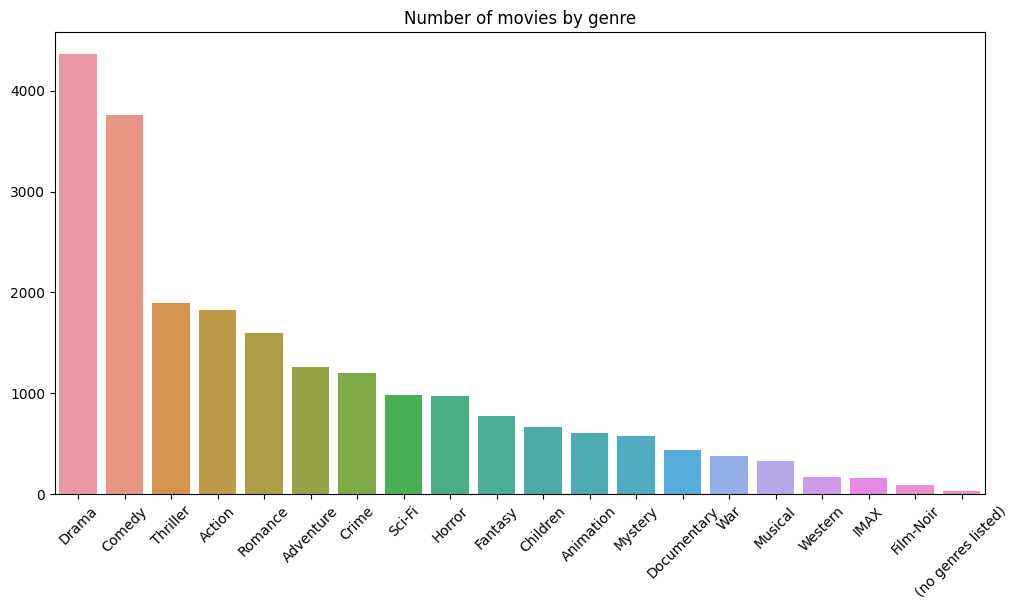

In [41]:
genre_count = {}
for index, row in movies.iterrows():
    for genre in row['genres']:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
genre_count = pd.Series(genre_count)
genre_count.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_count.index, y=genre_count.values)
plt.xticks(rotation=45)
plt.title("Number of movies by genre")
plt.show()

가장 많은 영화가 드라마, 코미디, 스릴러 장르에 속해있는데 사실 드라마, 코미디 장르가 대부분을 차지.

### 2.2 영화별 평균 평점 분석
- 평점에 따라 영화 추천이 가능할 것으로 예상되어, 평점 분포가 어떻게 되어있는지 확인

In [42]:
movie_mean_rating = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
movie_mean_rating = movie_mean_rating.reset_index()

# 상위 10개 영화 출력
top10_movies = movie_mean_rating.head(10).merge(movies, on='movieId')
print("상위 10개 영화")
print(top10_movies[['movieId', 'title', 'rating']])

상위 10개 영화
   movieId                                      title  rating
0    88448      Paper Birds (Pájaros de papel) (2010)     5.0
1   100556                 Act of Killing, The (2012)     5.0
2   143031                            Jump In! (2007)     5.0
3   143511                               Human (2015)     5.0
4   143559                        L.A. Slasher (2015)     5.0
5     6201                           Lady Jane (1986)     5.0
6   102217             Bill Hicks: Revelations (1993)     5.0
7   102084               Justice League: Doom (2012)      5.0
8     6192  Open Hearts (Elsker dig for evigt) (2002)     5.0
9   145994                     Formula of Love (1984)     5.0


이거로 알기 어려워서 시각화를 진행함.

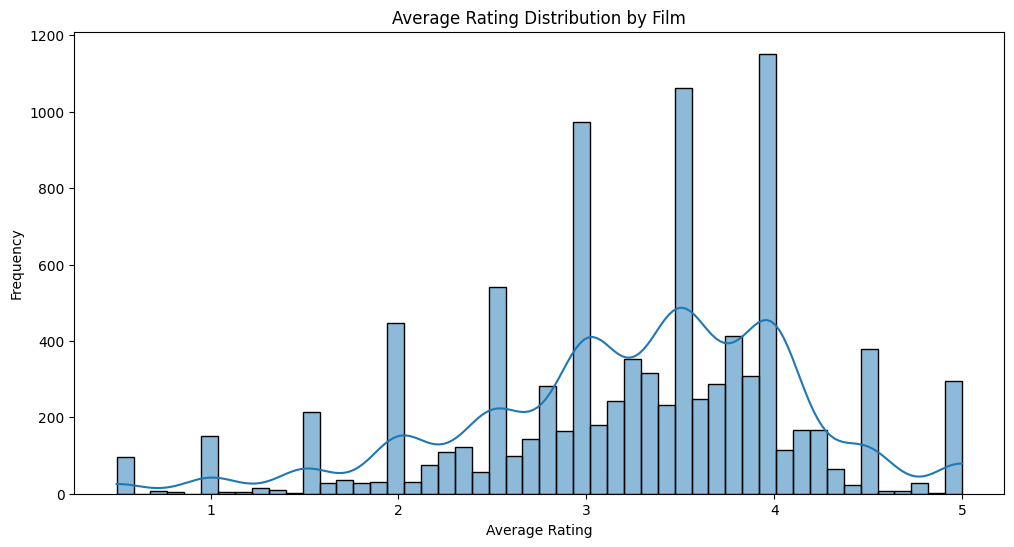

In [43]:
# 영화 데이터랑 합친 후에 시각화 진행
movie_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
merged_movie_ratings = movie_ratings.merge(movies, on='movieId')

# 선으로 이어두기
plt.figure(figsize=(12, 6))
sns.histplot(data=merged_movie_ratings, x='rating', bins=50, kde=True)
plt.title("Average Rating Distribution by Film")
plt.ylabel("Frequency")
plt.xlabel("Average Rating")
plt.show()

꼬불꼬불하긴 하지만 (정수대 평점이 많기에), 평균 평점의 분포는 거의 정규분포를 이루고있다. 

평균 평점이 3.0 ~ 4.0 사이인 영화가 가장 많이 관측되고 있고, 대부분의 영화가 보통 이상의 만족도를 주는 것으로 이해할 수 있겠다.

다만, 평점이 높다라고 해서 정확한 예측을 진행하는것은 아니기에, 그냥 일반적으로 어느정도 품질은 보장하고있구나 정도로 해석.

### 2.3 사용자별 평점 개수 및 평균 평점 분석

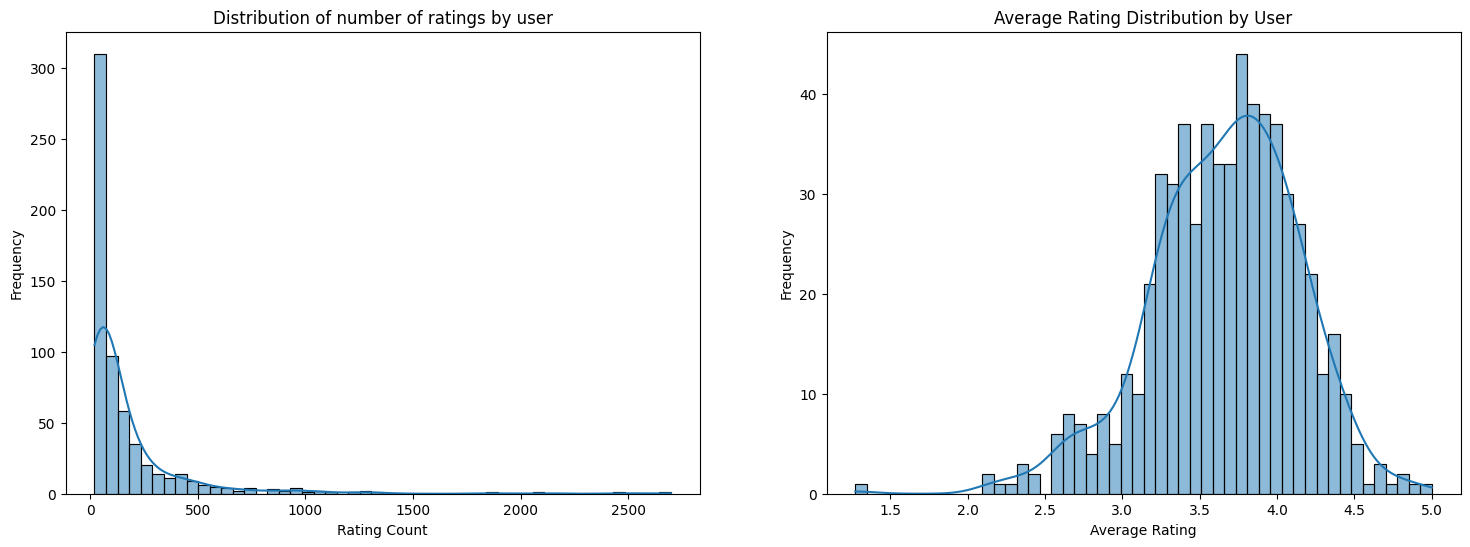

In [44]:
user_rating_count = ratings.groupby('userId')['rating'].count()
user_rating_mean = ratings.groupby('userId')['rating'].mean()

# 사용자별 평점 개수 및 평균 평점 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=user_rating_stats, x='count', ax=ax1, bins=50, kde=True)
ax1.set_title("Distribution of number of ratings by user")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Rating Count")

sns.histplot(data=user_rating_stats, x='mean', ax=ax2, bins=50, kde=True)
ax2.set_title("Average Rating Distribution by User")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Average Rating")

plt.show()

In [45]:
# 평점 개수와 평균 평점을 하나의 데이터프레임으로 합치기
user_rating_stats = pd.concat([user_rating_count, user_rating_mean], axis=1)
user_rating_stats.columns = ['count', 'mean']
user_rating_stats.sort_values(by='count', ascending=False, inplace=True)

# 상위 10개 사용자 출력
print("상위 10개 사용자")
print(user_rating_stats.head(10))

상위 10개 사용자
        count      mean
userId                 
414      2698  3.391957
599      2478  2.642050
474      2108  3.398956
448      1864  2.847371
274      1346  3.235884
610      1302  3.688556
68       1260  3.233730
380      1218  3.673235
606      1115  3.657399
288      1055  3.145972


평점을 많이 부여한 사용자는 매우 드물고(왼쪽), 대부분의 유저들이 비슷한 수준으로 만족도를 평가(오른쪽, 정규분포 유사)했다는 것을 알 수 있음

### 2.4 연도별 영화 개수 및 평균 평점 분석
- 특정 연도에 나온 영화와 평균 평점간의 연관이 있을까 해서 알아보았다.

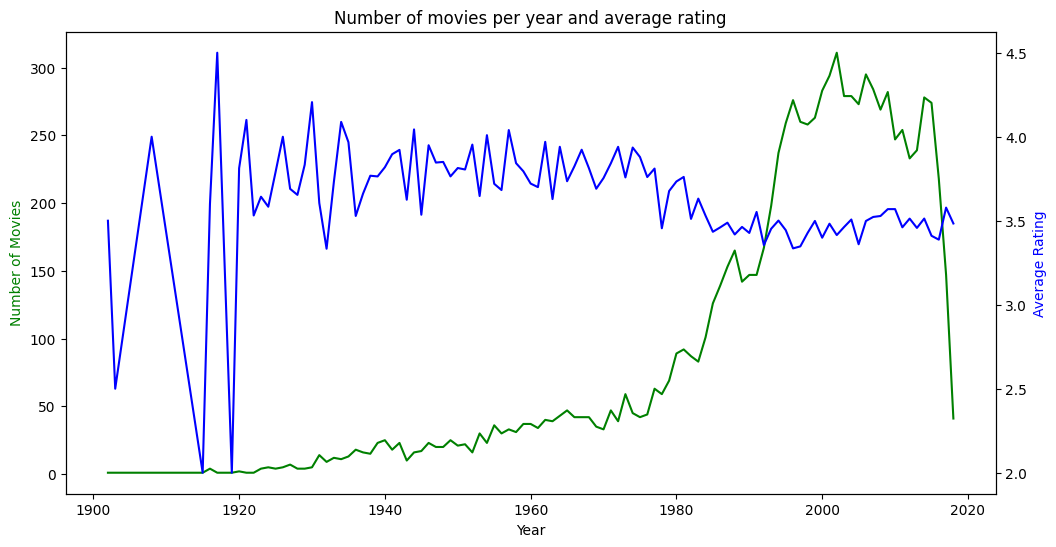

In [46]:
# 4. 연도별 영화 개수 및 평균 평점 분석
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = movies['year'].astype(float)

# 연도별 영화 개수
year_movie_count = movies.groupby('year')['title'].count()

# 연도별 평균 평점
year_movie_ratings = ratings.merge(movies, on='movieId')
year_movie_mean_rating = year_movie_ratings.groupby('year')['rating'].mean()

# 연도별 영화 개수 및 평균 평점 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(year_movie_count.index, year_movie_count.values, 'g-')
ax2.plot(year_movie_mean_rating.index, year_movie_mean_rating.values, 'b-')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies', color='g')
ax2.set_ylabel('Average Rating', color='b')

plt.title("Number of movies per year and average rating")
plt.show()

### 2.5 영화별 태그 개수 분석
- 영화 추천에 있어서, 태그가 가장 중요한 연관 요소로 고려되기에 이 부분에 대한 데이터도 보았다.

In [47]:
movie_tag_count = tags.groupby('movieId')['tag'].count().sort_values(ascending=False)
movie_tag_count = movie_tag_count.reset_index()

# 상위 10개 영화 출력
top10_tagged_movies = movie_tag_count.head(10).merge(movies, on='movieId')
print("상위 10개 태그가 많은 영화")
print(top10_tagged_movies[['movieId', 'title', 'tag']])

상위 10개 태그가 많은 영화
   movieId                                              title  tag
0      296                                Pulp Fiction (1994)  181
1     2959                                  Fight Club (1999)   54
2      924                       2001: A Space Odyssey (1968)   41
3      293  Léon: The Professional (a.k.a. The Professiona...   35
4     7361       Eternal Sunshine of the Spotless Mind (2004)   34
5     1732                           Big Lebowski, The (1998)   32
6     4878                                Donnie Darko (2001)   29
7    79132                                   Inception (2010)   26
8      260          Star Wars: Episode IV - A New Hope (1977)   26
9   135536                               Suicide Squad (2016)   19


### 2.6 가장 인기 있는 태그 상위 10개 분석
- 2.5에서 봤듯이 엄청 많은 태그를 가진 영화들이 많은것으로 보이는데, 그럼 태그 개수 분포는 어떤지 알아보게 되었다.

Top 10 Most Popular Tags
In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
surreal               23
Disney                23
religion              22
sci-fi                21
quirky                21
Name: tag, dtype: int64


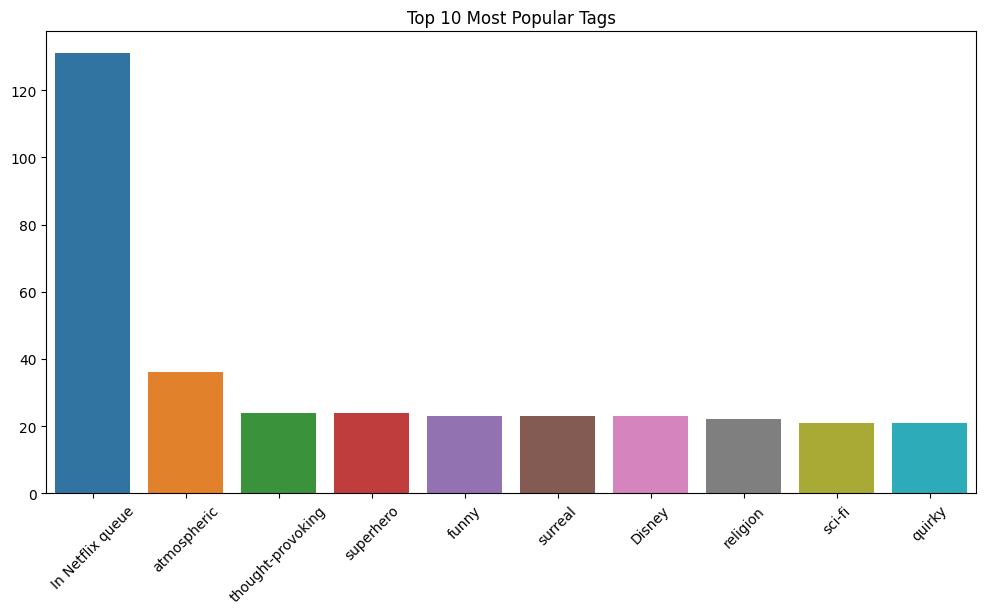

In [48]:
# 6. 가장 인기 있는 태그 상위 10개 분석
popular_tags = tags['tag'].value_counts().sort_values(ascending=False).head(10)
print("Top 10 Most Popular Tags")
print(popular_tags)

plt.figure(figsize=(12, 6))
sns.barplot(x=popular_tags.index, y=popular_tags.values)
plt.xticks(rotation=45)
plt.title("Top 10 Most Popular Tags")
plt.show()

"In Netflix queue"라는 태그만 크고, 나머지는 고르게 분포되어있는 모습이다.

태그 기반으로 추천을 해주는 경우, 넷플릭스에 포함되어있는지에 대한 여부는 지우고 추천해줘도 좋을법 하다.

# 2. 무비렌즈 데이터 기반 추천 모델 성능평가 및 결과 출력
---

- Surprise 라이브러리를 활용해서 알고리즘을 2종씩 적용하고, 성능평가를 할 예정.
- Memory-based CF 알고리즘
    - `KNNBasic`, `KNNWithMeans` 사용
- Model-based CF 알고리즘
    - `SVD`, `NMF` 사용 (NMF의 경우 처음 보는 개념이라서, 충분히 검색하여 적용. [여기](https://angeloyeo.github.io/2020/10/15/NMF.html)를 참고했음)


In [49]:
from surprise import Dataset, Reader
from surprise import KNNBasic, KNNWithMeans, SVD, NMF
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

# 데이터 로드
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# 훈련 및 테스트 데이터 분할
trainset, testset = train_test_split(data, test_size=0.25)

In [50]:
# 알고리즘 정의
algorithms = {
    'KNNBasic': KNNBasic(),
    'KNNWithMeans': KNNWithMeans(),
    'SVD': SVD(),
    'NMF': NMF()
}

In [52]:
def movie_id_to_title(movie_id):
    title = movies[movies['movieId'] == movie_id]['title'].values[0]
    return title

for name, algo in algorithms.items():
    print(f"{name} 알고리즘:")
    
    # 교차 검증을 사용한 성능 평가
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    rmse_mean = cv_results['test_rmse'].mean()
    mae_mean = cv_results['test_mae'].mean()
    print(f"평균 RMSE: {rmse_mean:.3f}, 평균 MAE: {mae_mean:.3f}")
    
    # 알고리즘 훈련 및 예측
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    # 특정 사용자(아까 EDA에서 나왔던, 평가를 젤 많이한 사람)에 대한 상위 10개 추천 결과 출력
    user_id = 599      
    user_ratings = [(iid, r_ui) for uid, iid, r_ui, est, _ in predictions if uid == user_id]
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top5_movies = user_ratings[:10]
    
    # 영화 ID를 제목으로 매핑하고 표 형식으로 출력
    top5_movies_with_titles = [(movie_id_to_title(iid), rating) for iid, rating in top5_movies]
    df = pd.DataFrame(top5_movies_with_titles, columns=['영화 제목', '평점'])
    print(f"상위 5개 추천 영화 (사용자 ID: {user_id}):")
    print(df)
    print("\n")

KNNBasic 알고리즘:
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
평균 RMSE: 0.948, 평균 MAE: 0.727
Computing the msd similarity matrix...
Done computing similarity matrix.
상위 5개 추천 영화 (사용자 ID: 599):
                                               영화 제목   평점
0         Rumble in the Bronx (Hont faan kui) (1995)  5.0
1                                       Akira (1988)  5.0
2  Star Wars: Episode VI - Return of the Jedi (1983)  5.0
3                                  Fight Club (1999)  5.0
4                           Big Lebowski, The (1998)  5.0
5         Ghost in the Shell (Kôkaku kidôtai) (1995)  5.0
6                         Lost in Translation (2003)  5.0
7                   Femme 

왜 아무리 해도 똑같지 ..?